In [8]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from operator import itemgetter
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn import tree
%matplotlib inline 

In [9]:
data = pd.read_csv('diabetes_prediction_dataset.csv')
#https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

In [10]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [11]:
le = LabelEncoder()
data['gender'] = le.fit_transform(data['gender'])
data = data.drop(columns=['smoking_history'])
data = data.drop(columns=['bmi'])
data = data.drop(columns=['heart_disease'])
data.head

<bound method NDFrame.head of        gender   age  hypertension  HbA1c_level  blood_glucose_level  diabetes
0           0  80.0             0          6.6                  140         0
1           0  54.0             0          6.6                   80         0
2           1  28.0             0          5.7                  158         0
3           0  36.0             0          5.0                  155         0
4           1  76.0             1          4.8                  155         0
...       ...   ...           ...          ...                  ...       ...
99995       0  80.0             0          6.2                   90         0
99996       0   2.0             0          6.5                  100         0
99997       1  66.0             0          5.7                  155         0
99998       0  24.0             0          4.0                  100         0
99999       0  57.0             0          6.6                   90         0

[100000 rows x 6 columns]>

In [12]:
data = data[data.index < 5000]
data.head()

,gender,age,hypertension,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,6.6,140,0
1,0,54.0,0,6.6,80,0
2,1,28.0,0,5.7,158,0
3,0,36.0,0,5.0,155,0
4,1,76.0,1,4.8,155,0


In [15]:
X = data.drop(['diabetes'], axis = 1)
y = data['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
#1. Модель бэггинга - случайный лес (Random Forest):

from sklearn.ensemble import RandomForestClassifier

# Создаем модель случайного леса с 100 деревьями
rf_model = RandomForestClassifier(n_estimators=100)

# Обучаем модель на тренировочных данных
rf_model.fit(X_train, y_train)

# Оцениваем качество модели на тестовых данных
accuracy = rf_model.score(X_test, y_test)
print("Accuracy: беггинг", accuracy)

#2. Модель бустинга - градиентный бустинг (Gradient Boosting):

from sklearn.ensemble import GradientBoostingClassifier

# Создаем модель градиентного бустинга с 100 деревьями и скоростью обучения 0.1
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)

# Обучаем модель на тренировочных данных
gb_model.fit(X_train, y_train)

# Оцениваем качество модели на тестовых данных
accuracy = gb_model.score(X_test, y_test)
print("Accuracy: бустинг", accuracy)


#3. Модель стекинга - мета-классификатор на основе логистической регрессии:


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

# Обучаем базовые модели на тренировочных данных
rf_preds = cross_val_predict(rf_model, X_train, y_train, cv=5, method='predict_proba')
gb_preds = cross_val_predict(gb_model, X_train, y_train, cv=5, method='predict_proba')

# Создаем мета-классификатор на основе логистической регрессии
meta_model = LogisticRegression()

# Обучаем мета-классификатор на прогнозах базовых моделей
meta_model.fit(np.hstack([rf_preds, gb_preds]), y_train)
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
rf_test_preds = rf_model.predict_proba(X_test)
gb_model.fit(X_train, y_train)
gb_test_preds = gb_model.predict_proba(X_test)

# Оцениваем качество модели на тестовых данных

meta_test_preds = meta_model.predict_proba(np.hstack([rf_test_preds, gb_test_preds]))
accuracy = meta_model.score(np.hstack([rf_test_preds, gb_test_preds]), y_test)
print("Accuracy: стекинг", accuracy) 

Accuracy: беггинг 0.958
Accuracy: бустинг 0.965
Accuracy: стекинг 0.965


Accuracy of Bagging Classifier: 96.50%
Accuracy of Random Forest Classifier: 96.20%


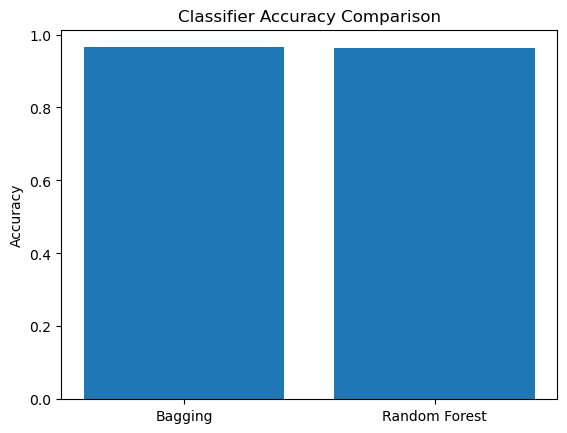

In [17]:
# Создаем три модели: решающее дерево, бэггинг и случайный лес

bg = gb_model
rf = rf_model

# Обучаем модели на обучающей выборке

bg.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Получаем предсказания на тестовой выборке

bg_pred = bg.predict(X_test)
rf_pred = rf.predict(X_test)

# Вычисляем точность предсказания каждой модели

bg_acc = accuracy_score(y_test, bg_pred)
rf_acc = accuracy_score(y_test, rf_pred)

# Выводим точность каждой модели на экран

print("Accuracy of Bagging Classifier: {:.2f}%".format(bg_acc*100))
print("Accuracy of Random Forest Classifier: {:.2f}%".format(rf_acc*100))

# Создаем график точности предсказания каждой модели
models = [ 'Bagging', 'Random Forest']
accuracies = [ bg_acc, rf_acc]
plt.bar(models, accuracies)
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy Comparison')
plt.show()